# Real-time video segmentation

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, ignite, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import cv2" || pip install -q opencv-python
%matplotlib inline

## Imports

In [2]:
from IPython.display import Video
from torch.utils.data import Dataset
import cv2
import os
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange
import torch

import monai
from monai.visualize.utils import blend_images
from monai.data.video_dataset import VideoFileDataset
from monai.data import DataLoader
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
import monai.transforms as mt
from monai.utils import set_determinism
from monai.apps import download_url

monai.config.print_config()

# Set deterministic training for reproducibility
set_determinism(seed=0)

MONAI version: 0.9.1+4.g82d58e4a
Numpy version: 1.21.2
Pytorch version: 1.10.2
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 82d58e4aeffb4f467c2e777678668b64efdaf02f
MONAI __file__: /mnt/data/rbrown/Documents/Code/MONAI/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 3.2.1
scikit-image version: 0.19.3
Pillow version: 8.4.0
Tensorboard version: 2.9.0
gdown version: 4.4.0
TorchVision version: 0.11.3
tqdm version: 4.62.3
lmdb version: 1.2.1
psutil version: 5.8.0
pandas version: 1.1.5
einops version: 0.4.0
transformers version: 4.14.1
mlflow version: 1.23.1
pynrrd version: 0.4.3

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)
endo_dir = os.path.join(root_dir, "endo_vid")

/mnt/data/rbrown/Documents/Data/MONAI


## Download data

In [4]:
vid_url = "https://github.com/rijobro/real_time_seg/raw/main/example_data/EndoVis2017/d1_im.mp4"
vid_hash = "9b103c07326439b0ea376018d7189384"
seg_url = "https://github.com/rijobro/real_time_seg/raw/main/example_data/EndoVis2017/d1_seg.mp4"
seg_hash = "da4eb17b6f8e4155fd81b962d46e5eff"
vid_filepath = os.path.join(endo_dir, "endo.mp4")
seg_filepath = os.path.join(endo_dir, "endo_seg.mp4")

download_url(vid_url, vid_filepath, vid_hash)
download_url(seg_url, seg_filepath, seg_hash)

2022-07-29 15:38:06,302 - INFO - Verified 'endo.mp4', md5: 9b103c07326439b0ea376018d7189384.
2022-07-29 15:38:06,303 - INFO - File exists: /mnt/data/rbrown/Documents/Data/MONAI/endo_vid/endo.mp4, skipped downloading.
2022-07-29 15:38:06,304 - INFO - Verified 'endo_seg.mp4', md5: da4eb17b6f8e4155fd81b962d46e5eff.
2022-07-29 15:38:06,305 - INFO - File exists: /mnt/data/rbrown/Documents/Data/MONAI/endo_vid/endo_seg.mp4, skipped downloading.


In [5]:
vid_transforms = mt.Compose(
    [
        mt.DivisiblePad(16),
        mt.ScaleIntensity(),
        mt.CastToType(torch.float32),
    ]
)
seg_transforms = mt.Compose([vid_transforms, mt.Lambda(lambda x: x[:1])])  #  rgb -> 1 chan


class CombinedVidDataset(Dataset):
    def __init__(self, img_file, seg_file, vid_transforms, seg_transforms):
        self.ds_img = VideoFileDataset(vid_filepath, vid_transforms)
        self.ds_lbl = VideoFileDataset(seg_filepath, seg_transforms)

    def __len__(self):
        return len(self.ds_img)

    def __getitem__(self, idx):
        return {"image": self.ds_img[idx], "label": self.ds_lbl[idx]}


ds = CombinedVidDataset(vid_filepath, seg_filepath, vid_transforms, seg_transforms)
dl = DataLoader(ds, batch_size=3, num_workers=0)

print(f"Number of frames in vid: {len(ds)}")

Number of frames in vid: 23


## Show selection

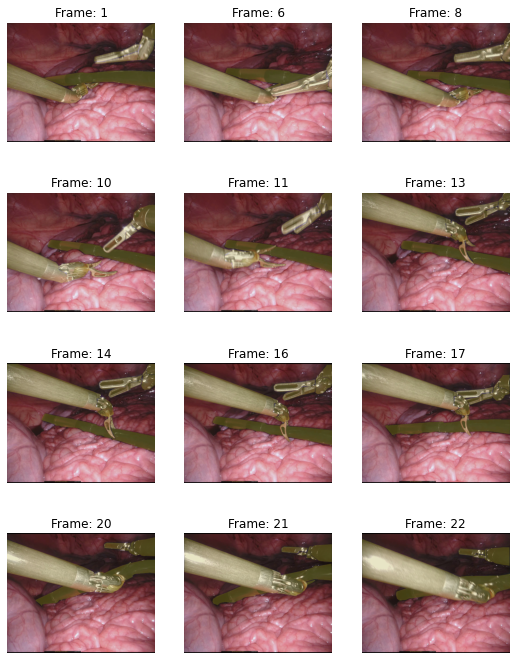

In [6]:
nrow, ncol = 4, 3
fig, axes = plt.subplots(nrow, ncol, figsize=(ncol * 3, nrow * 3), facecolor='white')
nexamples = nrow * ncol
frames = sorted(np.random.choice(len(ds), size=nexamples, replace=False))
for frame, ax in zip(frames, axes.flatten()):
    _ds = ds[frame]
    img, lbl = _ds["image"], _ds["label"]
    blended = blend_images(img, lbl, cmap="viridis", alpha=0.2)
    blended = np.moveaxis(blended, 0, -1)  # RGB to end
    ax.imshow(blended)
    ax.set_title(f"Frame: {frame}")
    ax.axis("off")

In [7]:
# Create network, loss fn., etc.
dice_metric = DiceMetric(reduction="mean")
post_trans = mt.Compose([
    mt.Activations(sigmoid=True),
    mt.AsDiscrete(threshold_values=0.5),
])
in_channels = ds[0]["image"].shape[0]
# create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(
    dimensions=2,
    in_channels=in_channels,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)
loss_function = DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-2)

Loss: 0.1038: 100%|██████████| 20/20 [03:22<00:00, 10.14s/it]


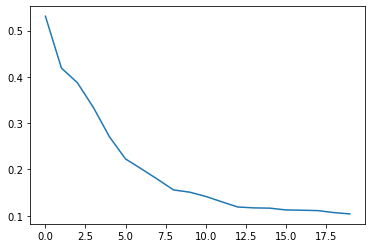

In [8]:
best_model_path = "best_model_video_seg.pth"

# start a typical PyTorch training
max_epochs = 20
val_interval = 1
best_metric = -1
best_metric_epoch = -1
losses = []

tr = trange(max_epochs)
for _ in tr:
    model.train()
    epoch_loss = 0

    for batch_data in dl:
        inputs, labels = batch_data["image"].to(
            device), batch_data["label"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(dl)
    losses.append(epoch_loss)
    tr.set_description(f"Loss: {epoch_loss:.4f}")

plt.plot(losses)

# Check segmentations

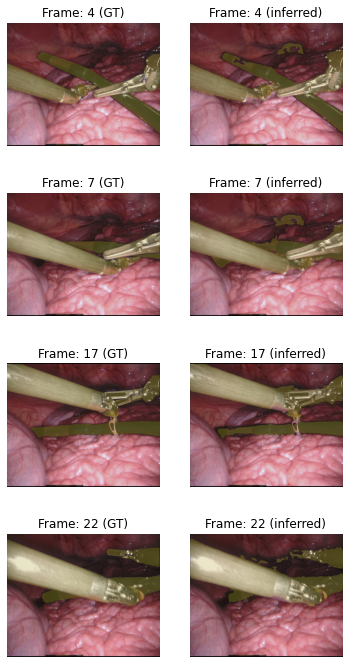

In [9]:
def infer_seg(im, model):
    """Infer single model and threshold."""
    inferred = model(im[None]) > 0
    return inferred[0].detach()


nrow, ncol = 4, 2
fig, axes = plt.subplots(nrow, ncol, figsize=(ncol * 3, nrow * 3), facecolor='white')
nexamples = nrow
frames = sorted(np.random.choice(len(ds), size=nexamples, replace=False))
for row, frame in enumerate(frames):
    _ds = ds[frame]
    img, lbl = _ds["image"], _ds["label"]
    inferred = infer_seg(img.to(device), model).cpu()
    for col, (_lbl, title) in enumerate(zip((lbl, inferred), ("GT", "inferred"))):
        blended = blend_images(img, _lbl, cmap="viridis", alpha=0.2)
        blended = np.moveaxis(blended, 0, -1)  # RGB to end
        axes[row, col].imshow(blended)
        axes[row, col].set_title(f"Frame: {frame} ({title})")
        axes[row, col].axis("off")

## Time the inference

In [10]:
img_gpu = ds[frame]["image"].to(device)
%timeit infer_seg(img_gpu, model)

43.3 ms ± 1.48 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Generating video

In [11]:


def get_available_codecs():
    all_codecs = {"mp4v": ".mp4", "X264": ".avi", "H264": ".mp4", "MP42": ".mp4", "MJPG": ".mjpeg", "DIVX": ".avi"}
    codecs = {}
    writer = cv2.VideoWriter()
    with tempfile.TemporaryDirectory() as tmp_dir:
        for codec, ext in all_codecs.items():
            fname = os.path.join(tmp_dir, f"test{ext}")
            fourcc = cv2.VideoWriter_fourcc(*codec)
            noviderr = writer.open(fname, fourcc, 1, (10, 10))
            if noviderr:
                codecs[codec] = ext
    writer.release()
    return codecs


codec, ext = next(iter(get_available_codecs().items()))
print(codec, ext)

mp4v .mp4


[ERROR:0@250.085] global /io/opencv/modules/videoio/src/cap_ffmpeg_impl.hpp (2927) open Could not find encoder for codec_id=27, error: Encoder not found
[ERROR:0@250.086] global /io/opencv/modules/videoio/src/cap_ffmpeg_impl.hpp (3002) open VIDEOIO/FFMPEG: Failed to initialize VideoWriter
[ERROR:0@250.086] global /io/opencv/modules/videoio/src/cap.cpp (595) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /io/opencv/modules/videoio/src/cap_images.cpp:253: error: (-5:Bad argument) CAP_IMAGES: can't find starting number (in the name of file): /tmp/tmp3f49ot8p/test.avi in function 'icvExtractPattern'


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'
[ERROR:0@250.086] global /io/opencv/modules/videoio/src/cap_ffmpeg_impl.hpp (2927) open Could not find encoder for codec_id=27, error: Encoder not found
[ERROR:0@250.086] global /io/opencv/modules/videoio/src/ca

In [13]:
def create_video(ds, output_file, fps, codec, ext):
    fourcc = cv2.VideoWriter_fourcc(*codec)
    codec_success = cv2.VideoWriter().open("test" + ext, fourcc, 1, (10, 10))
    if not codec_success:
        raise RuntimeError("failed to open video.")

    print(f"{len(ds)} frames @ {fps} fps: {output_file}...")
    for idx in trange(len(ds)):
        img = ds[idx]["image"]
        inferred = infer_seg(img.to(device), model).detach().cpu()
        blended = blend_images(img, inferred, cmap="viridis", alpha=0.2)
        if idx == 0:
            width_height = blended.shape[1:][::-1]
            video = cv2.VideoWriter(output_file, fourcc, fps, width_height)
        blended = (np.moveaxis(blended, 0, -1) * 254).astype(np.uint8)
        blended = cv2.cvtColor(blended, cv2.COLOR_RGB2BGR)
        video.write(blended)
    video.release()
    if not os.path.isfile(output_file):
        raise RuntimeError("video not created:", output_file)
    print("Success!")


# endovis2017 is 2Hz:
# https://endovissub2017-roboticinstrumentsegmentation.grand-challenge.org/
fps = 2
inferred_vid = os.path.join(endo_dir, "inferred.mp4")
create_video(ds, inferred_vid, fps, codec, ext)

23 frames @ 2 fps: /mnt/data/rbrown/Documents/Data/MONAI/endo_vid/inferred.mp4...


100%|██████████| 23/23 [00:04<00:00,  4.97it/s]

Success!


In [14]:
Video(inferred_vid, embed=True, height=300)